<a href="https://colab.research.google.com/github/divaamahajan/logAnalysis-kafka-spark/blob/main/kafkaLogs/parquet_log_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable Web Server Log Analytics with Apache Spark


# Setting up Dependencies

In [2]:
!pip install spark
!pip install pyspark
!pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58747 sha256=80d36759f86ea31bd1064d2771284640be6cc7444437d954f3df98e64323e024
  Stored in directory: /root/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=006a0cd144aa817d829ee33c5af4465425c4a50f4a1f3e8aa81793ecf417119c
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession

# Get the existing SparkSession
spark = SparkSession.builder.getOrCreate()

# Create SQLContext
sqlContext = SQLContext(spark)


In [4]:
spark

In [5]:
sqlContext

In [6]:
import re
import pandas as pd

## Basic Regular Expressions

In [7]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<re.Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<re.Match object; span=(25, 36), match=' in PySpark'> 25 36


# Loading and Viewing the parquet files


In [34]:
import glob
import zipfile

# Find the path of the zip file
zip_file_path = glob.glob('*.zip')[0]

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()


In [35]:
parquet_files = glob.glob('parquet/*.parquet')
parquet_files

['parquet/part-00000-88388fb2-d737-474b-abed-dee2a47e0856-c000.snappy.parquet',
 'parquet/part-00000-ef9610f0-d588-4f59-9331-bd52e4f17869-c000.snappy.parquet',
 'parquet/part-00000-d3acb701-a68a-4c88-82dc-9d7dd25d76f2-c000.snappy.parquet',
 'parquet/part-00000-9415283f-c125-4c12-8be2-bae552aa8192-c000.snappy.parquet',
 'parquet/part-00000-6f96cad8-1d37-46b4-b67e-76d0c9ea81a7-c000.snappy.parquet',
 'parquet/part-00000-0c822a6e-970f-4e1a-9a1d-cd598193bce5-c000.snappy.parquet',
 'parquet/part-00000-d794c4f4-4ec8-435d-81d9-c29062bc1a5b-c000.snappy.parquet',
 'parquet/part-00000-d9a79b41-c904-4722-a1b1-2b5f0b55eb68-c000.snappy.parquet']

### Metadata of dataframe

In [63]:
# Read the Parquet files into a DataFrame
logs_df = spark.read.parquet(*parquet_files)

# Show the first 10 rows of the DataFrame
logs_df.show(10, truncate=False)


+---------------+----+-----+---+----+------+------+---------------------------------------------------------------------------------+------------+-------------+-----+
|ip_address     |year|month|day|hour|minute|method|endpoint                                                                         |http_version|response_code|bytes|
+---------------+----+-----+---+----+------+------+---------------------------------------------------------------------------------+------------+-------------+-----+
|75.77.74.150   |2118|Dec  |26 |    |      |GET   |/Archives/edgar/data/0001518715/000151871522000011/0001518715-22-000011-index.htm|1.0         |200          |5302 |
|176.120.174.1  |2118|Dec  |26 |    |      |POST  |/Archives/edgar/data/0001411207/000156459021052445/0001564590-21-052445-index.htm|1.0         |500          |34727|
|162.200.34.120 |2118|Dec  |26 |    |      |POST  |/Archives/edgar/data/0000101382/000156459022006546/umbf-10k_20211231.htm         |1.0         |403          |25428

In [64]:
logs_df.printSchema()

root
 |-- ip_address: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- http_version: string (nullable = true)
 |-- response_code: string (nullable = true)
 |-- bytes: string (nullable = true)



In [65]:
type(logs_df)

pyspark.sql.dataframe.DataFrame

Convert a dataframe to an RDD if needed

In [66]:
logs_df_rdd = logs_df.rdd
type(logs_df_rdd)

pyspark.rdd.RDD

### Viewing sample data in our dataframe

In [40]:
logs_df.show(10, truncate=False)

+---------------+----+-----+---+----+------+------+---------------------------------------------------------------------------------+------------+-------------+-----+
|ip_address     |year|month|day|hour|minute|method|endpoint                                                                         |http_version|response_code|bytes|
+---------------+----+-----+---+----+------+------+---------------------------------------------------------------------------------+------------+-------------+-----+
|75.77.74.150   |2118|Dec  |26 |    |      |GET   |/Archives/edgar/data/0001518715/000151871522000011/0001518715-22-000011-index.htm|1.0         |200          |5302 |
|176.120.174.1  |2118|Dec  |26 |    |      |POST  |/Archives/edgar/data/0001411207/000156459021052445/0001564590-21-052445-index.htm|1.0         |500          |34727|
|162.200.34.120 |2118|Dec  |26 |    |      |POST  |/Archives/edgar/data/0000101382/000156459022006546/umbf-10k_20211231.htm         |1.0         |403          |25428

In [41]:
logs_df_rdd.take(10)

[Row(ip_address='75.77.74.150', year='2118', month='Dec', day='26', hour='', minute='', method='GET', endpoint='/Archives/edgar/data/0001518715/000151871522000011/0001518715-22-000011-index.htm', http_version='1.0', response_code='200', bytes='5302'),
 Row(ip_address='176.120.174.1', year='2118', month='Dec', day='26', hour='', minute='', method='POST', endpoint='/Archives/edgar/data/0001411207/000156459021052445/0001564590-21-052445-index.htm', http_version='1.0', response_code='500', bytes='34727'),
 Row(ip_address='162.200.34.120', year='2118', month='Dec', day='26', hour='', minute='', method='POST', endpoint='/Archives/edgar/data/0000101382/000156459022006546/umbf-10k_20211231.htm', http_version='1.0', response_code='403', bytes='25428'),
 Row(ip_address='133.224.84.239', year='2118', month='Dec', day='26', hour='', minute='', method='GET', endpoint='/Archives/edgar/data/0001179929/000117992922000054/a2022definitiveproxy.htm', http_version='1.0', response_code='304', bytes='27248'

# Data Wrangling
Clean and parse dataset to extract structured attributes with meaningful information from each log message.


In [42]:
print((logs_df.count(), len(logs_df.columns)))

(120001, 11)


## Adding days of the week

In [71]:
from pyspark.sql.functions import col, concat, date_format, lit, to_date, when

# Convert month column to numeric format
month_mapping = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

logs_df = logs_df.withColumn('month_num', lit(None).cast('string'))

for month, month_num in month_mapping.items():
    logs_df = logs_df.withColumn('month_num', 
                                 when(col('month') == month, month_num).otherwise(col('month_num')))

# Add the day_of_week column
logs_df = logs_df.withColumn('date_str', concat(col('year'), lit('-'), col('month_num'), lit('-'), col('day')))
logs_df = logs_df.withColumn('date', to_date(logs_df['date_str'], 'yyyy-MM-dd'))
logs_df = logs_df.withColumn('day_of_week', date_format(logs_df['date'], 'EEEE'))

# Drop the date_str column
logs_df = logs_df.drop('date_str')

# Show the updated DataFrame
logs_df.show()


+---------------+----+-----+---+----+------+------+--------------------+------------+-------------+-----+---------+-----------+----------+
|     ip_address|year|month|day|hour|minute|method|            endpoint|http_version|response_code|bytes|month_num|day_of_week|      date|
+---------------+----+-----+---+----+------+------+--------------------+------------+-------------+-----+---------+-----------+----------+
|   75.77.74.150|2118|  Dec| 26|    |      |   GET|/Archives/edgar/d...|         1.0|          200| 5302|       12|     Monday|2118-12-26|
|  176.120.174.1|2118|  Dec| 26|    |      |  POST|/Archives/edgar/d...|         1.0|          500|34727|       12|     Monday|2118-12-26|
| 162.200.34.120|2118|  Dec| 26|    |      |  POST|/Archives/edgar/d...|         1.0|          403|25428|       12|     Monday|2118-12-26|
| 133.224.84.239|2118|  Dec| 26|    |      |   GET|/Archives/edgar/d...|         1.0|          304|27248|       12|     Monday|2118-12-26|
| 211.239.196.64|2118|  Dec

## Finding Missing Values

__Note:__ :  _big dataset_ is residing on disk which can potentially be present in multiple nodes in a spark cluster.

In [75]:
logs_df.columns

['ip_address',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'method',
 'endpoint',
 'http_version',
 'response_code',
 'bytes',
 'month_num',
 'day_of_week',
 'date']

In [76]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+
|ip_address|year|month|day|hour|minute|method|endpoint|http_version|response_code|bytes|month_num|day_of_week|date|
+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+
|         0|   0|    0|  0|   0|     0|     0|       0|           0|            0|    0|        1|          1|   1|
+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+



In [77]:
null_month_num_rows = logs_df.filter(logs_df['month_num'].isNull())
null_month_num_rows.show()

+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+
|ip_address|year|month|day|hour|minute|method|endpoint|http_version|response_code|bytes|month_num|day_of_week|date|
+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+
|          |    |     |   |    |      |      |        |            |             |     |     null|       null|null|
+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+



In [78]:
logs_df = logs_df.dropna(subset=['month_num'])


In [79]:
logs_df.select('year').distinct().rdd.flatMap(lambda x: x).collect()


['2118']

In [80]:
logs_df.printSchema()

root
 |-- ip_address: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- http_version: string (nullable = true)
 |-- response_code: string (nullable = true)
 |-- bytes: string (nullable = true)
 |-- month_num: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- date: date (nullable = true)



In [81]:
logs_df.limit(5).toPandas()

,ip_address,year,month,day,hour,minute,method,endpoint,http_version,response_code,bytes,month_num,day_of_week,date
0,75.77.74.150,2118,Dec,26,,,GET,/Archives/edgar/data/0001518715/00015187152200...,1.0,200,5302,12,Monday,2118-12-26
1,176.120.174.1,2118,Dec,26,,,POST,/Archives/edgar/data/0001411207/00015645902105...,1.0,500,34727,12,Monday,2118-12-26
2,162.200.34.120,2118,Dec,26,,,POST,/Archives/edgar/data/0000101382/00015645902200...,1.0,403,25428,12,Monday,2118-12-26
3,133.224.84.239,2118,Dec,26,,,GET,/Archives/edgar/data/0001179929/00011799292200...,1.0,304,27248,12,Monday,2118-12-26
4,211.239.196.64,2118,Dec,26,,,GET,/Archives/edgar/data/0000081391/00009324711200...,1.0,200,32034,12,Monday,2118-12-26


Let's now cache `logs_df` since we will be using it extensively for our data analysis section in the next part!

In [82]:
logs_df.cache()

DataFrame[ip_address: string, year: string, month: string, day: string, hour: string, minute: string, method: string, endpoint: string, http_version: string, response_code: string, bytes: string, month_num: string, day_of_week: string, date: date]

# Data Analysis on Web Logs (EDA)

Exploratory data analysis (EDA)


## Byte Size Statistics

In [84]:
byte_size_summary_df = logs_df.describe(['bytes'])
byte_size_summary_df.toPandas()

,summary,bytes
0,count,120000
1,mean,29975.596575
2,stddev,17334.347684501685
3,min,1
4,max,9998


In [86]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['bytes']).alias('min_byte_size'),
             F.max(logs_df['bytes']).alias('max_byte_size'),
             F.mean(logs_df['bytes']).alias('mean_byte_size'),
             F.stddev(logs_df['bytes']).alias('std_byte_size'),
             F.count(logs_df['bytes']).alias('count_byte_size'))
        .toPandas())

,min_byte_size,max_byte_size,mean_byte_size,std_byte_size,count_byte_size
0,1,9998,29975.596575,17334.347685,120000


## HTTP Response Code Analysis


In [87]:
response_freq_df = (logs_df
                     .groupBy('response_code')
                     .count()
                     .sort('response_code')
                     .cache())

In [88]:
print('Total distinct HTTP Response Codes:', response_freq_df.count())

Total distinct HTTP Response Codes: 7


In [89]:
status_freq_pd_df = (response_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,response_code,count
0,200,17284
4,404,17173
3,403,17135
5,500,17133
2,304,17131
6,502,17079
1,303,17065


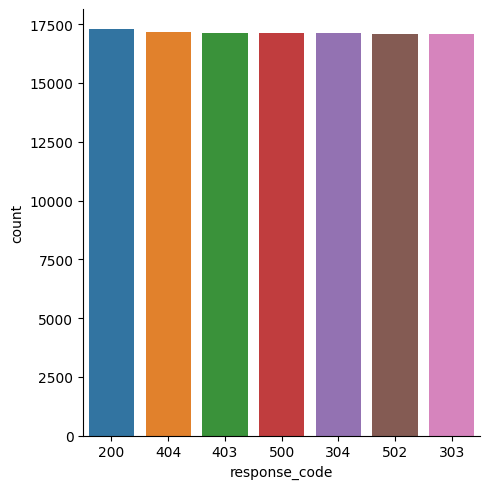

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='response_code', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['response_code'])

The resulting DataFrame log_freq_df will have an additional column named `log(count)`, which contains the logarithm of the values in the `count` column ie. the logarithm (base 'e') of the count value. The purpose of applying the logarithm function in this case might be to transform the count values into a different scale or to normalize them for analysis or visualization purposes.



In [91]:
log_freq_df = response_freq_df.withColumn('log(count)', F.log(response_freq_df['count']))
log_freq_df.show()

+-------------+-----+-----------------+
|response_code|count|       log(count)|
+-------------+-----+-----------------+
|          200|17284|9.757536497051824|
|          303|17065|9.744784861340808|
|          304|17131|9.748644966730458|
|          403|17135| 9.74887843430871|
|          404|17173|9.751093661983862|
|          500|17133|9.748761707332973|
|          502|17079|9.745604917619191|
+-------------+-----+-----------------+



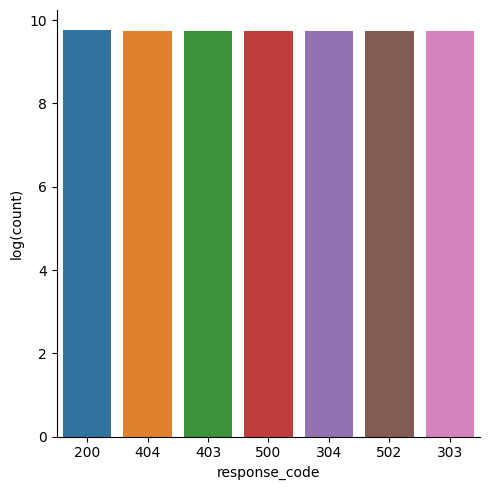

In [92]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='response_code', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['response_code'])

By examining the data, we can make the following observations:

- The most frequent response code is '200' with a count of 17,284. Its corresponding logarithm is approximately 9.7575.
- Other response codes like '303', '304', '403', '404', '500', and '502' also have high counts and their respective logarithm values.

## 200 Response Codes Analysis

### Counting 200 Response Codes


In [121]:
ok_df = logs_df.filter(logs_df["response_code"] == 200).cache()
print(('Total 200 responses: {}').format(ok_df.count()))

Total 200 responses: 17284


### Listing the Top Twenty 200 Response Code Endpoints


In [122]:
endpoints_200_count_df = (ok_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_200_count_df.show(truncate=False)

+---------------------------------------------------------------------------------------+-----+
|endpoint                                                                               |count|
+---------------------------------------------------------------------------------------+-----+
|/Archives/edgar/data/0001168220/000116822009000023/form10k-a_123108.htm                |152  |
|/Archives/edgar/data/0001091667/000109166722000024/chtr-20211231.htm                   |141  |
|/Archives/edgar/data/27673/0001104659-12-037692.txt                                    |141  |
|/Archives/edgar/data/0000004281/000119312517062657/R96.htm                             |139  |
|/Archives/edgar/data/0000205007/000114554923015369/0001145549-23-015369.txt            |137  |
|/Archives/edgar/data/1826671/000121390023023294/0001213900-23-023294.txt               |137  |
|/Archives/edgar/data/0001760283/000121390021017155/s131124_10k.htm                     |136  |
|/Archives/edgar/data/925548/00009215300

### Listing the Top Twenty 200 Response Code ip_addresss


In [123]:
ip_addresss_200_count_df = (ok_df
                          .groupBy("ip_address")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

ip_addresss_200_count_df.show(truncate=False)

+---------------+-----+
|ip_address     |count|
+---------------+-----+
|200.235.72.159 |1    |
|181.62.14.189  |1    |
|37.3.220.78    |1    |
|119.140.89.180 |1    |
|84.106.114.163 |1    |
|169.65.170.125 |1    |
|116.15.217.208 |1    |
|55.58.138.209  |1    |
|37.197.57.106  |1    |
|104.0.40.147   |1    |
|66.245.41.183  |1    |
|160.101.108.92 |1    |
|33.127.106.105 |1    |
|28.89.134.48   |1    |
|131.231.171.173|1    |
|192.217.108.83 |1    |
|58.179.245.191 |1    |
|165.110.95.126 |1    |
|12.23.148.181  |1    |
|58.205.152.141 |1    |
+---------------+-----+



### 200 OK per Day


In [124]:
errors_by_date_sorted_df = (ok_df
                                .groupBy("date")
                                .count()
                                .sort("date"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,date,count
0,2118-12-26,17284


All 200 OK codes fall on 2118-Dec-26 

### Days of the Week with 200 Status Codes

In [125]:
from pyspark.sql.functions import col

week_counts_df = ok_df.groupBy('day_of_week').count().orderBy(col('count').asc())
week_counts_df.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|     Monday|17284|
+-----------+-----+



### Hourly 200 Errors

In [126]:
hourly_avg_errors_sorted_df = (ok_df
                                   .groupBy('hour')
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()
hourly_avg_errors_sorted_pd_df

,hour,count
0,,17284


All 200 OK fall at midnight

## 404 Response Codes Analysis

### Counting 404 Response Codes


In [ ]:
not_found_df = logs_df.filter(logs_df["response_code"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 17173


### Listing the Top Twenty 404 Response Code Endpoints


In [ ]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+---------------------------------------------------------------------------------+-----+
|endpoint                                                                         |count|
+---------------------------------------------------------------------------------+-----+
|/Archives/edgar/data/0001179929/000117992923000043/moh-20230320_g24.jpg          |141  |
|/Archives/edgar/data/1390098/000121390023023295/0001213900-23-023295.txt         |139  |
|/Archives/edgar/data/0001002638/000100263815000016/0001002638-15-000016-index.htm|139  |
|/Archives/edgar/data/0001260125/000114420419015093/tv516458_10k.htm              |138  |
|/Archives/edgar/data/0001724128/000121390021017151/s131120_10k.htm               |138  |
|/Archives/edgar/data/0001798682/000121390021017167/s131143_10k.htm               |138  |
|/Archives/edgar/data/27419/0001104659-12-037689.txt                              |138  |
|/Archives/edgar/data/0000205007/000114554923005581/primary_doc.xml               |136  |
|/Archives

### Listing the Top Twenty 404 Response Code ip_addresss


In [ ]:
ip_addresss_404_count_df = (not_found_df
                          .groupBy("ip_address")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

ip_addresss_404_count_df.show(truncate=False)

+--------------+-----+
|ip_address    |count|
+--------------+-----+
|211.192.19.243|1    |
|203.239.62.214|1    |
|57.99.6.85    |1    |
|170.110.43.62 |1    |
|113.168.71.233|1    |
|17.124.63.123 |1    |
|166.80.39.27  |1    |
|92.213.198.148|1    |
|221.135.7.230 |1    |
|73.69.108.205 |1    |
|198.64.95.135 |1    |
|52.252.133.84 |1    |
|130.87.117.238|1    |
|84.87.158.202 |1    |
|57.111.250.153|1    |
|209.225.219.7 |1    |
|95.78.148.135 |1    |
|60.41.3.141   |1    |
|60.240.27.28  |1    |
|107.255.13.99 |1    |
+--------------+-----+



### 404 Errors per Day


In [ ]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy("date")
                                .count()
                                .sort("date"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,date,count
0,2118-12-26,17173


All 404 errors fall on 2118-Dec-26 

### Days of the Week with 404 Status Codes

In [ ]:
from pyspark.sql.functions import col

week_counts_df = not_found_df.groupBy('day_of_week').count().orderBy(col('count').asc())
week_counts_df.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|     Monday|17173|
+-----------+-----+



### Hourly 404 Errors

In [ ]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy('hour')
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()
hourly_avg_errors_sorted_pd_df

,hour,count
0,,17173


All 404 errors fall at midnight

## IP Address Analysis

### Analyzing Frequent IP Address
Get the count of total accesses by each `ip_address` and then sort by the counts and display only the top ten most frequent ip_addresss.

In [93]:
ip_address_sum_df =(logs_df
               .groupBy('ip_address')
               .count()
               .sort('count', ascending=False).limit(10))

ip_address_sum_df.show(truncate=False)

+---------------+-----+
|ip_address     |count|
+---------------+-----+
|136.107.117.116|2    |
|55.135.36.93   |2    |
|163.218.128.230|1    |
|99.46.28.107   |1    |
|164.21.58.62   |1    |
|211.192.19.243 |1    |
|21.51.229.253  |1    |
|3.20.196.136   |1    |
|55.134.128.41  |1    |
|200.235.72.159 |1    |
+---------------+-----+



### Total number of Unique ip_addresss

In [ ]:
unique_ip_address_count = (logs_df
                     .select('ip_address')
                     .distinct()
                     .count())
unique_ip_address_count

119998

### Number of Unique Daily ip_addresss


In [ ]:
ip_address_day_distinct_df = logs_df.select(logs_df.ip_address,'day').dropDuplicates()
ip_address_day_distinct_df.show(5, truncate=False)

+--------------+---+
|ip_address    |day|
+--------------+---+
|155.58.151.29 |26 |
|163.82.174.139|26 |
|165.179.232.65|26 |
|193.21.255.115|26 |
|108.76.56.192 |26 |
+--------------+---+
only showing top 5 rows



**`daily_unique_ip_addresss_df`**

A DataFrame with two columns:

| column  | explanation                                        |
| ------- | -------------------------------------------------- |
| `day`   | the day of the month                               |
| `count` | the number of unique requesting ip_addresss for that day |

In [ ]:
dir(pd.options)

['compute', 'display', 'io', 'mode', 'plotting', 'styler']

In [ ]:
def_mr = pd.options.display.max_rows
pd.options.display.max_rows = 10
daily_ip_addresss_df = (ip_address_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_ip_addresss_df = daily_ip_addresss_df.toPandas()
daily_ip_addresss_df

,day,count
0,26,119998


## EndPoints Analysis

### Display the Top 20 Frequent EndPoints
The number of hits to endpoints (URIs) in the log. 
- Group by the `endpoint` column, aggregate by count, 
- sort in descending order like the previous part.

In [95]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

In [96]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/Archives/edgar/data/000132756719000032/000132...,863
1,/Archives/edgar/data/0001704304/00009296381900...,861
2,/Archives/edgar/data/0001203957/00011931251022...,853
3,/Archives/edgar/data/1356093/00008843000800001...,853
4,/Archives/edgar/data/0001260125/00011442041901...,852
5,/Archives/edgar/data/0001179929/00011799292300...,851
6,/Archives/edgar/data/1319616/00012091911901959...,850
7,/Archives/edgar/data/0001608293/00011931251422...,850
8,/Archives/edgar/data/0000318833/00003542042100...,847
9,/Archives/edgar/data/1390098/00012139002302329...,846


### Top 10 Error Endpoints
Sorted list containing the endpoints and the number of times that they were accessed with a non-200 return code and show the top ten.

In [97]:
not200_df = (logs_df
               .filter(logs_df['response_code'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

In [98]:
error_endpoints_freq_df.show(truncate=False)

+---------------------------------------------------------------------------------+-----+
|endpoint                                                                         |count|
+---------------------------------------------------------------------------------+-----+
|/Archives/edgar/data/0001704304/000092963819000386/form10k.htm                   |746  |
|/Archives/edgar/data/1356093/000088430008000018/0000884300-08-000018.txt         |743  |
|/Archives/edgar/data/000132756719000032/0001327567-19-000032-index.html          |739  |
|/Archives/edgar/data/0000318833/000035420421000574/SEC13G_Filing.htm             |736  |
|/Archives/edgar/data/0001203957/000119312510223947/0001193125-10-223947-index.htm|734  |
|/Archives/edgar/data/0001591698/000104746914000931/a2218171zs-1a.htm             |732  |
|/Archives/edgar/data/0001179929/000117992923000043/moh-20230320_g29.jpg          |732  |
|/Archives/edgar/data/1319616/000120919119019599/0001209191-19-019599-index.htm   |730  |
|/Archives

### Endpoint that received the highest number of invocations on a specific day of the week

Calculating the count of invocations for each unique combination of day of the week and endpoint

In [ ]:
from pyspark.sql.functions import date_format, count, max
# Group the data by day of the week and endpoint, and count the number of invocations
grouped_df = logs_df.groupBy('day_of_week', 'endpoint').agg(count('*').alias('invocations'))
grouped_df.show(10, truncate=True)


+-----------+--------------------+-----------+
|day_of_week|            endpoint|invocations|
+-----------+--------------------+-----------+
|     Monday|/Archives/edgar/d...|        811|
|     Monday|/Archives/edgar/d...|        800|
|     Monday|/Archives/edgar/d...|        850|
|     Monday|/Archives/edgar/d...|        805|
|     Monday|/Archives/edgar/d...|        758|
|     Monday|/Archives/edgar/d...|        806|
|     Monday|/Archives/edgar/d...|        815|
|     Monday|/Archives/edgar/d...|        787|
|     Monday|/Archives/edgar/d...|        786|
|     Monday|/Archives/edgar/d...|        782|
+-----------+--------------------+-----------+
only showing top 10 rows



Select the highest count for each unique day of week

In [ ]:
# Avoids the join operation. 
# Utilize window functions to rank the rows and directly filter the rows with the highest invocations.
# This can be advantageous when dealing with large datasets since it avoids the overhead of the join operation.

from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

# Add a row number column based on the invocations in descending order for each day_of_week
windowSpec = Window.partitionBy('day_of_week').orderBy(grouped_df['invocations'].desc())
ranked_df = grouped_df.withColumn('rank', row_number().over(windowSpec))

# Filter the ranked DataFrame to retain only the rows with rank 1 (highest invocations)
max_invocations_df = ranked_df.filter(ranked_df['rank'] == 1)

# Summarize the results and display the day_of_week, endpoint, and invocations with max invocations
max_invocations_df.select('day_of_week', 'endpoint', 'invocations').show()

+-----------+--------------------+-----------+
|day_of_week|            endpoint|invocations|
+-----------+--------------------+-----------+
|     Monday|/Archives/edgar/d...|        863|
+-----------+--------------------+-----------+



All invocations fall on a Monday

## Method Analysis

### Analyzing Frequent Methods

In [129]:
methods_sum_df =(logs_df
               .groupBy('method')
               .count()
               .sort('count', ascending=False))

methods_sum_df.show(truncate=False)

+------+-----+
|method|count|
+------+-----+
|DELETE|30074|
|POST  |30067|
|GET   |29957|
|PUT   |29902|
+------+-----+



<ipython-input-134-dbaf134bd0dc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(methods, rotation=45)


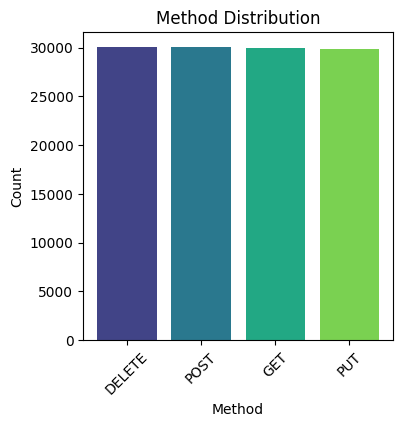

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the method names and counts from the DataFrame
methods = methods_sum_df.select('method').rdd.flatMap(lambda x: x).collect()
counts = methods_sum_df.select('count').rdd.flatMap(lambda x: x).collect()

# Set the color palette
colors = sns.color_palette('viridis', len(methods))

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(4, 4))

# Create a bar plot with colors
ax.bar(methods, counts, color=colors)

# Set the labels and title
ax.set_xlabel('Method')
ax.set_ylabel('Count')
ax.set_title('Method Distribution')

# Rotate the x-axis labels
ax.set_xticklabels(methods, rotation=45)

# Display the plot
plt.show()


### Methods to Response Codes

In [141]:
from pyspark.sql import functions as F

# Group by response_code and method, and count the occurrences
grouped_df = logs_df.groupBy('response_code', 'method').count()

# Show the grouped DataFrame
grouped_df.show(truncate=False)


+-------------+------+-----+
|response_code|method|count|
+-------------+------+-----+
|502          |DELETE|4265 |
|200          |GET   |4359 |
|403          |GET   |4336 |
|403          |DELETE|4349 |
|404          |PUT   |4339 |
|303          |GET   |4237 |
|200          |PUT   |4295 |
|502          |PUT   |4334 |
|502          |POST  |4298 |
|304          |POST  |4277 |
|404          |GET   |4158 |
|304          |GET   |4327 |
|502          |GET   |4182 |
|200          |DELETE|4383 |
|303          |POST  |4281 |
|404          |DELETE|4280 |
|303          |PUT   |4268 |
|500          |POST  |4278 |
|304          |DELETE|4275 |
|304          |PUT   |4252 |
+-------------+------+-----+
only showing top 20 rows



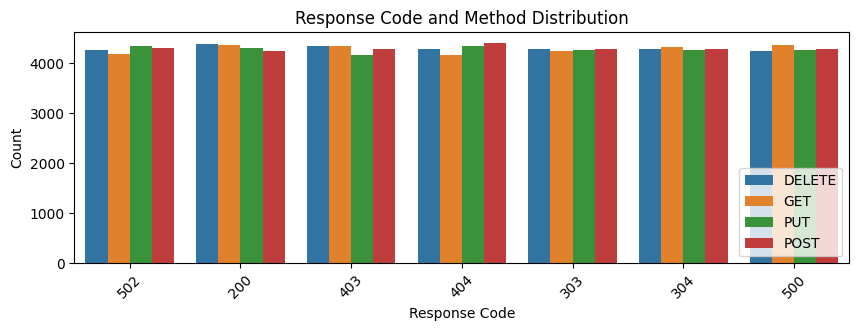

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the response_code, method, and counts from the grouped DataFrame
response_codes = grouped_df.select('response_code').rdd.flatMap(lambda x: x).collect()
methods = grouped_df.select('method').rdd.flatMap(lambda x: x).collect()
counts = grouped_df.select('count').rdd.flatMap(lambda x: x).collect()

# Create the color palette
colors = sns.color_palette('tab10', len(response_codes))

# Set the figure size
plt.figure(figsize=(10, 3))

# Create a bar plot with clustered bars and colored by response_code
sns.barplot(x=response_codes, y=counts, hue=methods, palette=colors)

# Set labels and title
plt.xlabel('Response Code')
plt.ylabel('Count')
plt.title('Response Code and Method Distribution')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Place the legend in the bottom right corner
plt.legend(loc='lower right')

# Show the plot
plt.show()


### Methods to IP Address

In [154]:
from pyspark.sql import functions as F

# Group by response_code and method, and count the occurrences
grouped_df = logs_df.groupBy('ip_address', 'method').count()

# Show the grouped DataFrame
grouped_df.show(truncate=False)


+---------------+------+-----+
|ip_address     |method|count|
+---------------+------+-----+
|130.72.85.37   |POST  |1    |
|28.164.235.25  |PUT   |1    |
|138.101.149.103|PUT   |1    |
|4.142.129.56   |GET   |1    |
|49.139.214.148 |GET   |1    |
|86.245.110.248 |GET   |1    |
|99.8.131.217   |GET   |1    |
|12.57.175.101  |DELETE|1    |
|102.208.14.68  |DELETE|1    |
|70.156.139.188 |PUT   |1    |
|5.4.119.82     |GET   |1    |
|77.201.220.118 |POST  |1    |
|24.48.77.112   |DELETE|1    |
|19.7.210.73    |GET   |1    |
|35.163.158.163 |GET   |1    |
|42.141.171.167 |POST  |1    |
|150.2.243.56   |PUT   |1    |
|202.97.35.233  |POST  |1    |
|11.50.12.216   |POST  |1    |
|57.174.205.134 |DELETE|1    |
+---------------+------+-----+
only showing top 20 rows



### Methods to Endpoints

In [157]:
from pyspark.sql import functions as F

# Group by response_code and method, and count the occurrences
grouped_df = logs_df.groupBy('endpoint', 'method').count()

# Show the grouped DataFrame
grouped_df.show(truncate=False)


+---------------------------------------------------------------------------------+------+-----+
|endpoint                                                                         |method|count|
+---------------------------------------------------------------------------------+------+-----+
|/Archives/edgar/data/0001439124/000129281422000788/                              |GET   |198  |
|/Archives/edgar/data/1932485/000110465923037622/tm239175d10_absee.htm            |GET   |178  |
|/Archives/edgar/data/0001035018/000119312507272779/g47607g69u06.jpg              |DELETE|182  |
|/Archives/edgar/data/0001729361/000121390021017176/s131100_10k.htm               |GET   |211  |
|/Archives/edgar/data/0000205007/000114554923005581/0001145549-23-005581.txt      |PUT   |190  |
|/Archives/edgar/data/0000004281/000119312517062657/R98.htm                       |PUT   |192  |
|/Archives/edgar/data/0001129068/000095013122003743/narot19cabsee_0818-1508.htm   |DELETE|193  |
|/Archives/edgar/data/24104/00

## Reset the max rows displayed in pandas

In [116]:
pd.set_option('display.max_rows', def_mr)



# **KMeans Clustering**

## **Data Transformation**

### Unique dates and time

In [273]:
logs_df.select('date').distinct().collect()

[Row(date=datetime.date(2118, 12, 26))]

In [274]:
logs_df.select('hour').distinct().collect()

[Row(hour='')]

In [275]:
logs_df.select('minute').distinct().collect()

[Row(minute='')]

Since there is only one date and time in our dataset, it does not contribute in clustering lets drop it

### Unique HTTP Version

In [276]:
logs_df.select('http_version').distinct().collect()

[Row(http_version='1.0')]

Since there is only one HTTP Version in our dataset, it does not contribute in clustering lets drop it

In [277]:
columns_to_drop = ['year', 'month', 'day', 'hour', 'minute', 'month_num', 'day_of_week', 'date', 'http_version']
cleaned_df = logs_df.drop(*columns_to_drop)
cleaned_df.show()

+---------------+------+--------------------+-------------+-----+---------+
|     ip_address|method|            endpoint|response_code|bytes|row_index|
+---------------+------+--------------------+-------------+-----+---------+
|   75.77.74.150|   GET|/Archives/edgar/d...|          200| 5302|        0|
|  176.120.174.1|  POST|/Archives/edgar/d...|          500|34727|        1|
| 162.200.34.120|  POST|/Archives/edgar/d...|          403|25428|        2|
| 133.224.84.239|   GET|/Archives/edgar/d...|          304|27248|        3|
| 211.239.196.64|   GET|/Archives/edgar/d...|          200|32034|        4|
| 152.154.66.105|   GET|/Archives/edgar/d...|          200|43782|        5|
|  41.76.166.189|   PUT|/Archives/edgar/d...|          304|53533|        6|
|  134.27.187.18|  POST|/Archives/edgar/d...|          404|15445|        7|
|   152.77.55.45|   PUT|/Archives/edgar/d...|          200|44416|        8|
|115.252.123.132|  POST|/Archives/edgar/d...|          500|11453|        9|
|  155.58.15

### Transform colums to index

In [278]:
from pyspark.ml.feature import StringIndexer

# Create a StringIndexer for each column
ip_indexer = StringIndexer(inputCol='ip_address', outputCol='ip_index')
method_indexer = StringIndexer(inputCol='method', outputCol='method_index')
endpoint_indexer = StringIndexer(inputCol='endpoint', outputCol='endpoint_index')

# Fit the StringIndexer models to the DataFrame
ip_indexer_model = ip_indexer.fit(cleaned_df)
method_indexer_model = method_indexer.fit(cleaned_df)
endpoint_indexer_model = endpoint_indexer.fit(cleaned_df)

# Transform the DataFrame to include the indexed columns
indexed_df = ip_indexer_model.transform(cleaned_df)
indexed_df = method_indexer_model.transform(indexed_df)
indexed_df = endpoint_indexer_model.transform(indexed_df)

# Show the DataFrame with the converted 'method' column
indexed_df.show()


+---------------+------+--------------------+-------------+-----+---------+--------+------------+--------------+
|     ip_address|method|            endpoint|response_code|bytes|row_index|ip_index|method_index|endpoint_index|
+---------------+------+--------------------+-------------+-----+---------+--------+------------+--------------+
|   75.77.74.150|   GET|/Archives/edgar/d...|          200| 5302|        0|106035.0|         2.0|          58.0|
|  176.120.174.1|  POST|/Archives/edgar/d...|          500|34727|        1| 45226.0|         1.0|          78.0|
| 162.200.34.120|  POST|/Archives/edgar/d...|          403|25428|        2| 37252.0|         1.0|          36.0|
| 133.224.84.239|   GET|/Archives/edgar/d...|          304|27248|        3| 20067.0|         2.0|          95.0|
| 211.239.196.64|   GET|/Archives/edgar/d...|          200|32034|        4| 67278.0|         2.0|          80.0|
| 152.154.66.105|   GET|/Archives/edgar/d...|          200|43782|        5| 31196.0|         2.0

### Min_MAX Scaler

**min_max scaler** is a way to get data in the range 0 to 1

**StandardScaler** if you need -1 to 1 range. Scale each variable to have a mean of 0 and a standard deviation of 1

We use scaling so that each variable has equal importance when fitting the k-means algorithm. Otherwise, the variables with the widest ranges would have too much influence.

In [284]:
from pyspark.sql.functions import col
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType

# Define the columns to be scaled
columns_to_scale = ['response_code', 'bytes', 'ip_index', 'method_index', 'endpoint_index']

# Cast the 'response_code' and 'bytes' columns to DoubleType
indexed_df = indexed_df.withColumn('response_code', col('response_code').cast(DoubleType()))
indexed_df = indexed_df.withColumn('bytes', col('bytes').cast(DoubleType()))

# Create a VectorAssembler to combine the columns into a vector column
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol='VectorAssembler')

# Transform the DataFrame to include the vector column
assembled_df = assembler.transform(indexed_df)

# Initialize the MinMaxScaler
scaler = MinMaxScaler(inputCol='VectorAssembler', outputCol='scaled_features')

# Fit and transform the DataFrame to obtain the scaled features
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

# Show the DataFrame with the scaled features
scaled_df.show()


+---------------+------+--------------------+-------------+-------+---------+--------+------------+--------------+--------------------+--------------------+
|     ip_address|method|            endpoint|response_code|  bytes|row_index|ip_index|method_index|endpoint_index|     VectorAssembler|     scaled_features|
+---------------+------+--------------------+-------------+-------+---------+--------+------------+--------------+--------------------+--------------------+
|   75.77.74.150|   GET|/Archives/edgar/d...|        200.0| 5302.0|        0|106035.0|         2.0|          58.0|[200.0,5302.0,106...|[0.0,0.0883514725...|
|  176.120.174.1|  POST|/Archives/edgar/d...|        500.0|34727.0|        1| 45226.0|         1.0|          78.0|[500.0,34727.0,45...|[0.99337748344370...|
| 162.200.34.120|  POST|/Archives/edgar/d...|        403.0|25428.0|        2| 37252.0|         1.0|          36.0|[403.0,25428.0,37...|[0.67218543046357...|
| 133.224.84.239|   GET|/Archives/edgar/d...|        304.0

##**Calculate PCA**

In [285]:
from pyspark.ml.feature import PCA

# Define the PCA model with the desired number of principal components
num_principal_components = 5
pca = PCA(k=num_principal_components, inputCol='scaled_features', outputCol='pca_features')

# Fit the PCA model to the scaled DataFrame
pca_model = pca.fit(scaled_df)

# Apply the PCA model to the scaled DataFrame
pca_df = pca_model.transform(scaled_df)

# Show the DataFrame with PCA features
pca_df.show()


+---------------+------+--------------------+-------------+-------+---------+--------+------------+--------------+--------------------+--------------------+--------------------+
|     ip_address|method|            endpoint|response_code|  bytes|row_index|ip_index|method_index|endpoint_index|     VectorAssembler|     scaled_features|        pca_features|
+---------------+------+--------------------+-------------+-------+---------+--------+------------+--------------+--------------------+--------------------+--------------------+
|   75.77.74.150|   GET|/Archives/edgar/d...|        200.0| 5302.0|        0|106035.0|         2.0|          58.0|[200.0,5302.0,106...|[0.0,0.0883514725...|[-0.6604946933221...|
|  176.120.174.1|  POST|/Archives/edgar/d...|        500.0|34727.0|        1| 45226.0|         1.0|          78.0|[500.0,34727.0,45...|[0.99337748344370...|[-0.3362853632736...|
| 162.200.34.120|  POST|/Archives/edgar/d...|        403.0|25428.0|        2| 37252.0|         1.0|          3

**Plot and check the variance of the components**
we need to decide how many features we’d like to keep based on the cumulative variance plot.

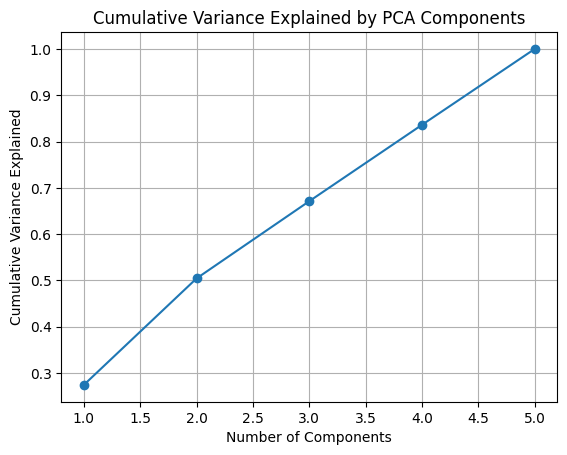

In [286]:

# Calculate the cumulative variance explained by the components
variance = pca_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(variance)

# Plot the cumulative variance explained by the components
plt.plot(range(1, num_principal_components + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCA Components')
plt.grid(True)
plt.show()

The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 2 components.

**Perform PCA with the chosen number of components.(2)**

In [287]:
from pyspark.ml.feature import PCA

# Define the number of components
num_components = 2  # Set the number of components you want to retain

# Initialize the PCA model
pca = PCA(k=num_components, inputCol='scaled_features', outputCol='pca_features')

# Fit the PCA model to the scaled DataFrame
pca_model = pca.fit(scaled_df)

# Transform the scaled DataFrame to include the PCA features
pca_df = pca_model.transform(scaled_df).withColumnRenamed('pca_features', 'features')

# Show the PCA DataFrame with the renamed column
pca_df.show(truncate=False)


+---------------+------+-----------------------------------------------------------------------------------+-------------+-------+---------+--------+------------+--------------+---------------------------------+--------------------------------------------------------------------------------------------------+-------------------------------------------+
|ip_address     |method|endpoint                                                                           |response_code|bytes  |row_index|ip_index|method_index|endpoint_index|VectorAssembler                  |scaled_features                                                                                   |features                                   |
+---------------+------+-----------------------------------------------------------------------------------+-------------+-------+---------+--------+------------+--------------+---------------------------------+-------------------------------------------------------------------------------

We’ll incorporate the newly obtained PCA scores in the K-means algorithm. That's how we can perform segmentation based on principal components scores instead of the original features.

## **Find the Optimal Number of Clusters**

**Distortion:**
It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used. ~ Inter-cluster Distances.


**Inertia:** 
It is the sum of squared distances of samples to their closest cluster center. ~Intra-cluster Distances.

---
We don’t know beforehand how many clusters is optimal so we must create a plot that displays the number of clusters along with the SSE*(sum of squared errors)* of the model.

Typically when we create this type of plot we look for an “elbow” where the sum of squares begins to “bend” or level off. This is typically the optimal number of clusters.

We iterate the values of k from 1 to 10 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

In [288]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

# Define the range of k values
k_values = range(2, 11)

# Initialize lists to store distortion and inertia values
distortion_values = []
inertia_values = []


# Iterate over the k values
for k in k_values:
    # Initialize the KMeans model
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    
    # Fit the KMeans model to the DataFrame
    model = kmeans.fit(pca_df)
    
     
    # Evaluate the clustering performance using Distortion
    distortion = model.summary.trainingCost
    distortion_values.append(distortion)
    
    # Evaluate the clustering performance using Inertia
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(model.transform(pca_df))
    inertia_values.append(silhouette_score)


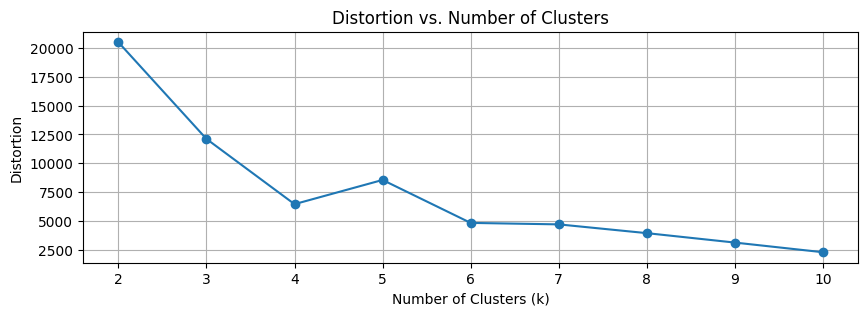

In [289]:

# Plot the distortion values
plt.figure(figsize=(10, 3))
plt.plot(k_values, distortion_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Distortion vs. Number of Clusters')
plt.grid(True)
plt.show()

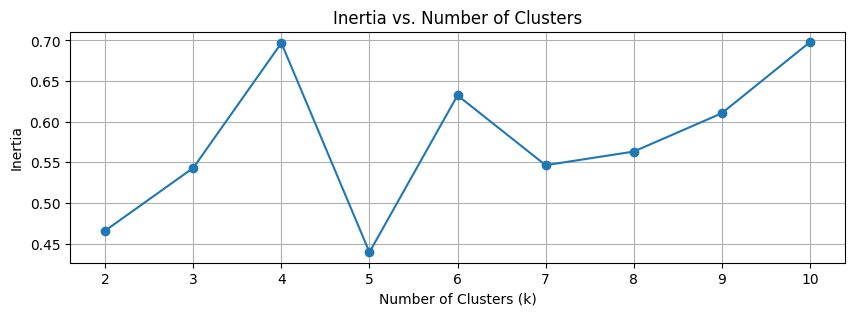

In [290]:

# Plot the inertia values
plt.figure(figsize=(10, 3))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.grid(True)
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 4

## **Perform K-Means Clustering with Optimal K**

In [291]:
# Set the optimal value of K
optimal_k = 4

# Initialize the KMeans model with the optimal K value
kmeans = KMeans(featuresCol='features', k=optimal_k, seed=42)

# Fit the KMeans model to the PCA DataFrame
kmeans_model = kmeans.fit(pca_df)

# Make predictions on the PCA DataFrame
clustered_df = kmeans_model.transform(pca_df)

# Show the predicted clusters
clustered_df.show()


+---------------+------+--------------------+-------------+-------+---------+--------+------------+--------------+--------------------+--------------------+--------------------+----------+
|     ip_address|method|            endpoint|response_code|  bytes|row_index|ip_index|method_index|endpoint_index|     VectorAssembler|     scaled_features|            features|prediction|
+---------------+------+--------------------+-------------+-------+---------+--------+------------+--------------+--------------------+--------------------+--------------------+----------+
|   75.77.74.150|   GET|/Archives/edgar/d...|        200.0| 5302.0|        0|106035.0|         2.0|          58.0|[200.0,5302.0,106...|[0.0,0.0883514725...|[-0.6604946933221...|         2|
|  176.120.174.1|  POST|/Archives/edgar/d...|        500.0|34727.0|        1| 45226.0|         1.0|          78.0|[500.0,34727.0,45...|[0.99337748344370...|[-0.3362853632736...|         3|
| 162.200.34.120|  POST|/Archives/edgar/d...|        40

In [292]:

# Get the cluster centers
cluster_centers = kmeans_model.clusterCenters()
print("Cluster Centers:")
for center in cluster_centers:
    print(center)


Cluster Centers:
[-0.1620232   0.23776818]
[-0.83501537  0.83998131]
[-0.82882076  0.23171503]
[-0.16870853  0.8440735 ]


In [293]:
unique_predictions = clustered_df.select("prediction").distinct()
unique_predictions.show()


+----------+
|prediction|
+----------+
|         1|
|         3|
|         2|
|         0|
+----------+



The cluster column contains a cluster number (0, 1, 2 or 3 ) that each row data was assigned to.

## Add predictions to logs

#**Data Visualisation**

##**Visualising the count of clusters**

In [263]:
grouped_df = clustered_df.groupBy("prediction").count()
grouped_df.toPandas()


,prediction,count
0,1,34121
1,3,34399
2,2,25738
3,0,25742


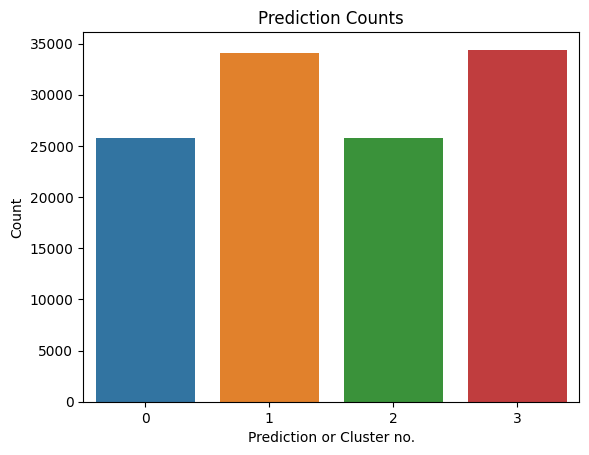

In [267]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the prediction column from the DataFrame
prediction_counts = clustered_df.groupBy("prediction").count()

# Convert the DataFrame to Pandas for plotting
prediction_counts_pd = prediction_counts.toPandas()

# Plot the prediction counts using sns
sns.barplot(data=prediction_counts_pd, x="prediction", y="count")
plt.xlabel("Prediction or Cluster no.")
plt.ylabel("Count")
plt.title("Prediction Counts")
plt.show()


## Visulizing clusters

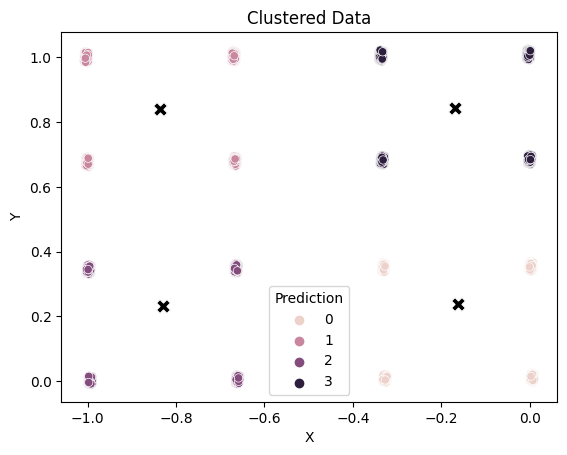

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame
clustered_df_pd = clustered_df.select("features", "prediction").toPandas()

# Extract the x and y coordinates from the pca_features column
clustered_df_pd["x"] = clustered_df_pd["features"].apply(lambda vec: vec[0])
clustered_df_pd["y"] = clustered_df_pd["features"].apply(lambda vec: vec[1])

# Convert the cluster centers to a Pandas DataFrame
cluster_centers_pd = pd.DataFrame(cluster_centers, columns=["x", "y"])

# Plot the scatter plot
sns.scatterplot(data=clustered_df_pd, x="x", y="y", hue="prediction")
sns.scatterplot(data=cluster_centers_pd, x="x", y="y", color="black", marker="X", s=100)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Clustered Data")
plt.legend(title="Prediction")
plt.show()


## Clusters and Methods

In [312]:
from pyspark.sql.functions import col

# Group by 'prediction' and 'method' columns and count occurrences
pred_method_counts = clustered_df.groupBy('prediction', 'method').count().orderBy(col('method')).orderBy(col('prediction'))

# Show the resulting DataFrame
pred_method_counts.show()


+----------+------+-----+
|prediction|method|count|
+----------+------+-----+
|         0|DELETE|12937|
|         0|  POST|12805|
|         1|   PUT|17087|
|         1|   GET|17034|
|         2|   GET|12923|
|         2|   PUT|12815|
|         3|DELETE|17137|
|         3|  POST|17262|
+----------+------+-----+



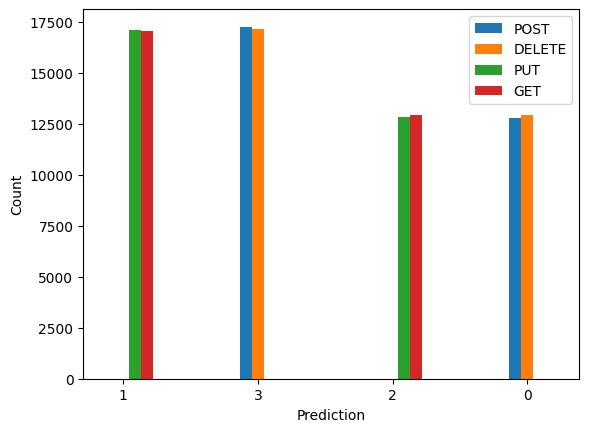

In [316]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the unique predictions and methods from the DataFrame
predictions = pred_method_counts.select('prediction').distinct().rdd.flatMap(lambda x: x).collect()
methods = pred_method_counts.select('method').distinct().rdd.flatMap(lambda x: x).collect()

# Count the occurrences of each prediction and method
counts = pred_method_counts.select('prediction', 'method', 'count').rdd \
    .map(lambda x: ((x[0], x[1]), x[2])) \
    .collectAsMap()

# Create an array of positions for the bar plot
positions = np.arange(len(predictions))

# Set the width of each bar
width = 0.35

# Create a bar plot for each method within each prediction
for i, method in enumerate(methods):
    method_counts = [counts.get((prediction, method), 0) for prediction in predictions]
    plt.bar(positions + (i - 1) * width / 4, method_counts, width=width/4, label=method)

plt.xlabel('Prediction')
plt.ylabel('Count')
plt.xticks(positions, predictions)
plt.legend()
plt.show()


HTTP Methods: Cluster 0 and cluster 3 exclusively contain logs with the HTTP methods POST and DELETE. This suggests that logs with these methods are specifically assigned to these clusters. Similarly, cluster 1 and cluster 2 exclusively contain logs with the HTTP methods PUT and GET. Logs with these methods are likely assigned to clusters 1 and 2.

## Clusters and Response Codes

In [317]:
from pyspark.sql.functions import col

# Group by 'prediction' and 'method' columns and count occurrences
pred_resp_counts = clustered_df.groupBy('prediction', 'response_code').count().orderBy(col('response_code')).orderBy(col('prediction'))

# Show the resulting DataFrame
pred_resp_counts.show()


+----------+-------------+-----+
|prediction|response_code|count|
+----------+-------------+-----+
|         0|        304.0| 8552|
|         0|        303.0| 8560|
|         0|        200.0| 8630|
|         1|        502.0| 8516|
|         1|        404.0| 8497|
|         1|        403.0| 8496|
|         1|        500.0| 8612|
|         2|        200.0| 8654|
|         2|        303.0| 8505|
|         2|        304.0| 8579|
|         3|        403.0| 8639|
|         3|        502.0| 8563|
|         3|        500.0| 8521|
|         3|        404.0| 8676|
+----------+-------------+-----+



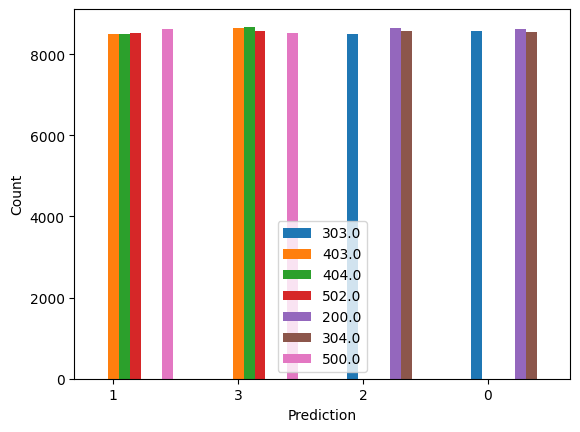

In [318]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the unique predictions and response_codes from the DataFrame
predictions = pred_resp_counts.select('prediction').distinct().rdd.flatMap(lambda x: x).collect()
response_codes = pred_resp_counts.select('response_code').distinct().rdd.flatMap(lambda x: x).collect()

# Count the occurrences of each prediction and response_code
counts = pred_resp_counts.select('prediction', 'response_code', 'count').rdd \
    .map(lambda x: ((x[0], x[1]), x[2])) \
    .collectAsMap()

# Create an array of positions for the bar plot
positions = np.arange(len(predictions))

# Set the width of each bar
width = 0.35

# Create a bar plot for each response_code within each prediction
for i, response_code in enumerate(response_codes):
    response_code_counts = [counts.get((prediction, response_code), 0) for prediction in predictions]
    plt.bar(positions + (i - 1) * width / 4, response_code_counts, width=width/4, label=response_code)

plt.xlabel('Prediction')
plt.ylabel('Count')
plt.xticks(positions, predictions)
plt.legend()
plt.show()


Cluster 0 and cluster 2 have similar response code distributions, indicating successful requests or client-side redirection. This suggests that logs with response codes such as 304, 303, and 200 are assigned to these clusters. On the other hand, cluster 1 and cluster 3 are characterized by response codes that suggest errors or issues with the requested resource or server-side problems, such as 502, 404, 403, and 500. Logs with these response codes are likely assigned to clusters 1 and 3.

# Conclusion

Based on the analysis, we can conclude that the four clusters (0, 1, 2, and 3) seem to be assigned to logs based on the combination of two factors: the type of response codes and the HTTP methods used.

| Cluster | Response Codes                    | HTTP Methods  |
|---------|----------------------------------|---------------|
| 0       | successful requests or client-side redirection (304, 303, 200)                    | POST, DELETE  |
| 1       | errors or issues with the requested resource or server-side problems (502, 404, 403, 500)               | PUT, GET      |
| 2       | successful requests or client-side redirection (304, 303, 200)                     | PUT, GET      |
| 3       | errors or issues with the requested resource or server-side problems (502, 404, 403, 500)               | POST, DELETE  |

Each cluster is associated with specific response codes and HTTP methods. The table provides a clear overview of how the clusters are assigned to the logs based on these characteristics.

- Cluster 0 is associated with successful requests or client-side redirection. It consists of logs with response codes 304, 303, and 200. The HTTP methods found in this cluster are only POST and DELETE.

- Cluster 1 is characterized by response codes that suggest errors or issues with the requested resource or server-side problems. It includes response codes 502, 404, 403, and 500. The HTTP methods present in this cluster are only PUT and GET.

- Cluster 2 represents successful requests or client-side redirection, similar to cluster 0. It contains response codes 200, 303, and 304. The HTTP methods in this cluster are only PUT and GET.

- Cluster 3 shares similarities with cluster 1 in terms of response codes that indicate errors or issues. It comprises response codes 403, 502, 500, and 404. The HTTP methods found in this cluster are only POST and DELETE.

In summary, the clustering seems to group the logs based on the combination of response codes and HTTP methods. Clusters 0 and 2 primarily consist of successful requests or client-side redirection logs, while clusters 1 and 3 are associated with response codes indicating errors or issues. The specific HTTP methods used in each cluster further differentiate the logs within the clusters.